In [132]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


In [133]:
CHAR_MAPPING = {
    "x" : -1,
    "." : 0,
    "H" : 1,
    "h" : 2, 
    "s": 3
}
COLOR_MAPPING = ["black", "white", "blue", "green", "red"]
MAP_SIMPLE_NAME = "map.txt"

def load_map(mapname, char_mapping):
    with open(mapname, 'r') as map_file:
        lines = map_file.readlines()
        width = int(lines[0])
        height = int(lines[1])
        map_numbers = [[char_mapping[chr] for chr in row[:-1]] for row in lines[2:]]
    return np.array(map_numbers, dtype = np.int32)


  
    #plt.figure()
    #plt.imshow(map , cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))

    #plt.show()

simple_map = load_map(MAP_SIMPLE_NAME, CHAR_MAPPING)
hider_pos = np.asarray(np.where(simple_map == CHAR_MAPPING["h"])).reshape(2)
seeker_pos = np.asarray(np.where(simple_map == CHAR_MAPPING["s"])).reshape(2)
#start configuration
MAP_START = np.copy(simple_map)
MAP_START[hider_pos[0], hider_pos[1]] = CHAR_MAPPING["."]
MAP_START[seeker_pos[0], seeker_pos[1]] = CHAR_MAPPING["."]




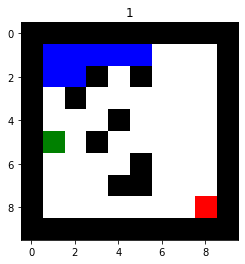

array([ 32250., -30000.])

In [160]:

def plot_map(map, generation):
    clear_output(wait=True)
    plt.figure()
    plt.title(generation)
    plt.imshow(map , cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))
    plt.show()

def get_percepts(map_env, pos, agent = "h"):
    VISION = 1
    return map_env [pos[0] - VISION : pos[0] + VISION + 1, pos[1] - VISION : pos[1] + VISION + 1]

ACTIONS = [[-1,0], [1, 0], [0, -1], [0, 1]]

def is_free(map_env, pos, agent):
    if (agent == "h"):
        return map_env[pos[0], pos[1]] in [CHAR_MAPPING["."], CHAR_MAPPING["H"], CHAR_MAPPING["h"]]
    return ((map_env[pos[0], pos[1]] in [CHAR_MAPPING["."], CHAR_MAPPING["s"]]) or 
        (map_env[pos[0], pos[1]] == CHAR_MAPPING["h"] and MAP_START[pos[0], pos[1]] != CHAR_MAPPING["H"]))


def do_action(map_env, pos, action, agent):
    new_pos = pos + ACTIONS[action]
    #print("ACTION")
    #print(pos)
    #print(ACTIONS[action])
    #print(new_pos)
    #print(new_pos)
    if is_free(map_env, new_pos, agent):
        #print(True)
        map_env[new_pos[0], new_pos[1]] = CHAR_MAPPING[agent]
        map_env[pos[0], pos[1]] = MAP_START[pos[0], pos[1]]
        return map_env, new_pos
    else:
        return map_env, pos




def simulate_step(map_env, pos_hide, pos_seek, policy_hide, policy_seek, **kwargs):

    action_seek = policy_seek(get_percepts(map_env, pos_seek, "s"), agent = "s", pos_hide = pos_hide, pos_seek = pos_seek, map_env = map_env, **kwargs )
    map_env, new_pos_seek = do_action(map_env, pos_seek, action_seek, "s")
    if(is_end(map_env, pos_hide, new_pos_seek)):
        return (map_env, pos_hide, new_pos_seek)        
    action_hide = policy_hide(get_percepts(map_env, pos_hide, "h"), agent = "h", pos_hide = pos_hide, pos_seek = pos_seek, map_env = map_env, **kwargs)
    map_env, new_pos_hide = do_action(map_env, pos_hide, action_hide, "h")
    #print(new_pos_hide, new_pos_seek)
    return (map_env, new_pos_hide, new_pos_seek)  #TODO add state

import time
from IPython.display import clear_output

def eval_map_state(map_env, pos_hide, pos_seek):
    #TODO
    if MAP_START[pos_hide[0], pos_hide[1]] == CHAR_MAPPING["H"]:
        state_hide = 0
    elif np.all(pos_hide == pos_seek):
        state_hide = -100000
    elif np.abs(pos_hide - pos_seek).sum() == 1:
        state_hide = -500
    else:
        state_hide = pos_hide[0] **2 + pos_hide[1] ** 2

    if np.all(pos_hide == pos_seek):
        state_seek = 100000
    elif np.abs((pos_hide - pos_seek)).sum() == 1:
        state_seek = 500
    else:
        state_seek = 0
    return (state_hide, state_seek)

def is_end(map_env, pos_hide, pos_seek):
    return np.all(pos_hide == pos_seek)

def simulate(map_orig, start_hide, start_seek, policy_hide, policy_seek, num_steps = 100, **kwargs):
    pos_hide, pos_seek = start_hide, start_seek
    SEEK_STATE = 0
    HIDE_STATE = 0
    map_env = np.copy(map_orig)
    scores = np.zeros(2)
    for step in range(num_steps):
        map_env, pos_hide, pos_seek = simulate_step(map_env, pos_hide, pos_seek, policy_hide, policy_seek, **kwargs)
        #time.sleep(0.2)
        if kwargs.get("plot") == True:
            plot_map(map_env, kwargs.get("generation"))
        scores += eval_map_state(map_env, pos_hide, pos_seek)
        scores += [600, -600]  #longer game is good for hider, shorter good for seeker
        if(is_end(map_env, pos_hide, pos_seek)):
            break
    return scores

def random_policy(percepts, agent, **kwargs):
    return np.random.randint(len(ACTIONS))
#print(simple_map)

simulate(simple_map, hider_pos, seeker_pos, random_policy, random_policy, generation = 1, num_steps=50, plot = True)


In [161]:

import neat
STATE_SEEK = 0
def NN_policy(percepts, agent, **kwargs):
    one_hot_input = []
    perc_flat = percepts.reshpe(-1)
    #ONE HOT ENCODING TRY
    #for percept in percepts.reshape(-1):
    #    perc_index = list(CHAR_MAPPING.values()).index(percept)
    #    one_hot_single = [0] * len(COLOR_MAPPING)
    #    one_hot_single[perc_index] = 1
    #    one_hot_input.extend(one_hot_single)
    one_hot_in = np.zeros(len(perc_flat), len(COLOR_MAPPING) - 1)
    one_hot_in[np.arange(len(perc_flat)), percepts + 1] = 1

    if agent == "h":
        network = kwargs.get("hide_net")
        pos = kwargs.get("pos_hide")
        
    else:
        network = kwargs.get("seek_net")
        pos = kwargs.get("pos_seek")
    output = np.copy(network.activate(np.array(one_hot_input)))
    #output = np.copy(network.activate(percepts.reshape(-1)/3))
    action = np.argmax(output)
    new_pos = pos + ACTIONS[action]
    #print(new_pos)
    #print(agent)
    while not is_free(kwargs.get("map_env"), new_pos, agent):
        #print("NOT_FREE")
        #print(np.argmax(output))
        output[np.argmax(output)] = -np.inf
        new_pos = pos + ACTIONS[np.argmax(output)]
        #print(pos)
        #print("-")
    #print("CHOSEN")
    #print(np.argmax(output))
    return np.argmax(output)


In [163]:
#todo fic parttools last two arguments
import functools
import os
FIT_SIMULATION_STEPS = 40
INTER_IT_COUNT = 20
POP_LEN = 20

def fitness_seek(genomes, config, start_hide, start_seek, default_map_state, hide_net):
    #print("FITNESS SEEK")
    for genome_id, genome in genomes:        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = simulate(default_map_state, start_hide, 
            start_seek, NN_policy, NN_policy, 
            num_steps = FIT_SIMULATION_STEPS, 
            seek_net = net, 
            hide_net = neat.nn.FeedForwardNetwork.create(hide_net, config), plot = False)[1]

def fitness_hide(genomes, config, start_hide, start_seek, default_map_state, seek_net):
    #print("FITNESS HIDE")
    for genome_id, genome in genomes:        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = simulate(default_map_state, start_hide, 
            start_seek, NN_policy, NN_policy, 
            num_steps = FIT_SIMULATION_STEPS, 
            seek_net = neat.nn.FeedForwardNetwork.create(seek_net, config), 
            hide_net = net, plot = False)[0]

def run_evolution(config_file, map_env, start_hide, start_seek,  main_it_count = 80):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    seek_pop = neat.Population(config)
    seek_pop.add_reporter(neat.StdOutReporter(True))
    stats_s = neat.StatisticsReporter()
    seek_pop.add_reporter(stats_s)
    seek_pop.add_reporter(neat.Checkpointer(INTER_IT_COUNT))

    hide_pop = neat.Population(config)
    hide_pop.add_reporter(neat.StdOutReporter(True))
    stats_h = neat.StatisticsReporter()
    hide_pop.add_reporter(stats_h)
    hide_pop.add_reporter(neat.Checkpointer(INTER_IT_COUNT))
    #TODO how to init winner
    winner_seek = neat.DefaultGenome(config)
    winner_hide = neat.DefaultGenome(config)

    for it in range(main_it_count):
        
        # Run for up to 300 generations.
        
        fit_seek_fixed = functools.partial(fitness_seek, default_map_state = map_env, start_hide = start_hide, 
            start_seek = start_seek, hide_net = winner_hide)
        winner_seek = seek_pop.run(fit_seek_fixed, INTER_IT_COUNT)
        #TODO how to return whole population ?
        seek_pop = neat.checkpoint.Checkpointer.restore_checkpoint("neat-checkpoint-" + str( INTER_IT_COUNT - 1) )
        seek_pop.add_reporter(neat.StdOutReporter(True))
        stats_s = neat.StatisticsReporter()
        seek_pop.add_reporter(stats_s)

        fit_hide_fixed = functools.partial(fitness_hide, default_map_state = map_env, start_hide = start_hide, 
            start_seek = start_seek, seek_net = winner_seek)
        winner_hide = hide_pop.run(fit_hide_fixed, INTER_IT_COUNT)
        #TODO how to return whole population ?
        #hide_pop = stats_h.best_unique_genomes(POP_LEN)
        hide_pop = neat.checkpoint.Checkpointer.restore_checkpoint("neat-checkpoint-" + str( INTER_IT_COUNT - 1) )
        hide_pop.add_reporter(neat.StdOutReporter(True))
        stats_h = neat.StatisticsReporter()
        hide_pop.add_reporter(stats_h)
        
    return (winner_hide, winner_seek, config)  
    

config_path = 'config-feedforward'
winner_hide, winner_seek, config = run_evolution(config_path, simple_map, hider_pos, seeker_pos)
#
    ##TODO adjust below
    ## Display the winning genome.
    #print('\nBest genome:\n{!s}'.format(winner))
#
    ## Show output of the most fit genome against training data.
    #print('\nOutput:')
    #winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    ##for xi, xo in zip(xor_inputs, xor_outputs):
    ##    output = winner_net.activate(xi)
    ##    print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))
#
    #node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    #visualize.draw_net(config, winner, True, node_names=node_names)
    #visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)
    #visualize.plot_stats(stats, ylog=False, view=True)
    #visualize.plot_species(stats, view=True)
#
    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)


 ****** Running generation 0 ****** 

Population's average fitness: -24000.00000 stdev: 0.00000
Best fitness: -24000.00000 - size: (4, 36) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.003, standard deviation 0.311
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    20  -24000.0    0.000     0
Total extinctions: 0
Generation time: 0.073 sec

 ****** Running generation 1 ****** 

Population's average fitness: -24000.00000 stdev: 0.00000
Best fitness: -24000.00000 - size: (4, 36) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.116, standard deviation 0.319
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    20  -24000.0    0.000     1
Total extinctions: 0
Generation time: 0.069 sec (0.071 average)

 ****** Running generation 2 ****** 

Population's average fitnes

In [178]:
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np
def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

In [179]:
import visualize
res = draw_net(config, winner_hide, True)

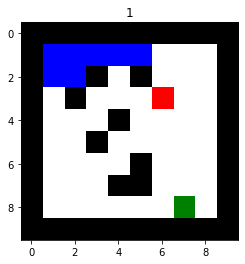

array([ 34268., -30000.])

In [142]:
simulate(simple_map, hider_pos, seeker_pos, random_policy, random_policy, generation = 1, num_steps=50, plot = True)

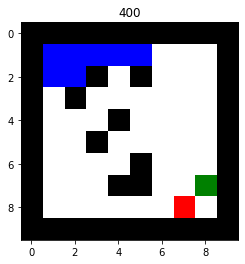

array([ 70494., -60000.])

In [157]:
simulate(simple_map, hider_pos, seeker_pos, 
        NN_policy, NN_policy, num_steps=100,
        hide_net = neat.nn.FeedForwardNetwork.create(winner_hide, config), 
        seek_net = neat.nn.FeedForwardNetwork.create(winner_seek, config),  generation = INTER_IT_COUNT * 20, plot = True)